In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
  
import sys

project_path = os.path.abspath(os.path.join('..'))

if project_path not in sys.path:
    sys.path.append(project_path)
    
plt.style.use('ggplot')

In [2]:
# os.makedirs('../data/DataLagsMayPkl', exist_ok=True)
# df = pd.DataFrame()
# for filename in tqdm(os.listdir('../data/DataLagsMay/')):
#     if '.csv' in filename and filename.replace("csv", "pkl") not in os.listdir('../data/DataLagsMayPkl'):
#         data = pd.read_csv(f'../data/DataLagsMay//{filename}')
#         data.to_pickle(f'../data/DataLagsMayPkl/{filename.replace("csv", "pkl")}', protocol=2)
# #         df = pd.concat([df, data])

# Read data

In [3]:
N_READ_FILES = 10

df = pd.DataFrame()
for filename in tqdm(os.listdir('../data/DataLagsMayPkl/')[:N_READ_FILES]):
    if '.pkl' in filename:
        data = pd.read_pickle(f'../data/DataLagsMayPkl/{filename}')
        ## Leave only last year
        data = data[data['period_start_dt'] > '2018-07-01']
        df = pd.concat([df, data])
        
df = df.reset_index(drop=True)
print(df.shape)
df_sample = df.copy()

  0%|          | 0/10 [00:00<?, ?it/s]

(1716201, 140)


In [4]:
location_dict = pd.read_csv('../data/LOCATION.csv', sep=';').rename(
    columns={
        'STORE_LOCATION_RK': 'store_location_rk',
        'STORE_LOCATION_LVL_RK3': 'city',
        'STORE_LOCATION_LVL_RK2': 'region'
    }
)[['store_location_rk', 'city', 'region']]

product_dict = pd.read_csv('../data/PRODUCT.csv', sep=';').rename(
    columns={
        'PRODUCT_RK': 'product_rk',
        'PRODUCT_LVL_RK3': 'product_lvl_rk3',
        'PRODUCT_LVL_RK2': 'product_lvl_rk2'
    }
)[['product_rk', 'product_lvl_rk3', 'product_lvl_rk2']]


data = df_sample.merge(location_dict, how='left', on='store_location_rk').\
    merge(product_dict, how='left', on='product_rk')

assert data['city'].isna().sum() == 0
assert data['region'].isna().sum() == 0

data.shape, df_sample.shape

((1716201, 144), (1716201, 140))

In [5]:
data['period_start_dt'].min(), data['period_start_dt'].max()

('2018-07-02', '2019-12-30')

In [6]:
train_split_date = '2019-11-04'

dataTrain = data[data['period_start_dt'] <= train_split_date]
dataTest = data[data['period_start_dt'] > train_split_date]


print(f'Train contains {round(dataTrain.shape[0] / data.shape[0], 2) * 100}% of data - {dataTrain.shape[0]} rows')
print(f'Test contains {round(dataTest.shape[0] / data.shape[0], 2) * 100}% of data - {dataTest.shape[0]} rows')


Train contains 88.0% of data - 1515927 rows
Test contains 12.0% of data - 200274 rows


In [7]:
dataTest['period_start_dt'].unique()

array(['2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02',
       '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30'],
      dtype=object)

In [8]:
main_cols = ['product_rk', 'store_location_rk',
             'PROMO1_FLAG', 'PROMO2_FLAG', 'PROMO12_FLAG',
             'city', 'product_lvl_rk3', 'product_lvl_rk2',
            'PRICE_REGULAR', 'PRICE_AFTER_DISC']
lag_cols = dataTrain.columns[(dataTrain.columns.str.contains('demand_')) & (~dataTrain.columns.str.contains('lag4'))]
lag_colsAll = dataTrain.columns[(dataTrain.columns.str.contains('demand_'))]

train_cols = main_cols + list(lag_cols)

X_train, y_train = dataTrain[train_cols].values, dataTrain['demand']
X_test, y_test = dataTest[train_cols].values, dataTest['demand']

In [9]:
data['product_rk'].unique().shape

(25456,)

# Dummy Baseline

In [10]:
print("MSE: ", mean_squared_error(np.ones(dataTest.shape[0]) * dataTrain['demand'].mean(), dataTest['demand']))
print("MAPE: ", mean_absolute_percentage_error(np.ones(dataTest.shape[0]) * dataTrain['demand'].mean(), dataTest['demand']))
print('MAE: ', mean_absolute_error(np.ones(dataTest.shape[0]) * dataTrain['demand'].mean(), dataTest['demand']))



MSE:  9.507807868733355
MAPE:  0.9176712076008342
MAE:  1.003530461440667


In [11]:
dummyDemand = dataTrain.groupby(['product_rk', 'store_location_rk', 'PROMO12_FLAG'])['demand'].mean().\
    reset_index().rename(columns={'demand': 'demandDummy'})



In [12]:
dataTest = dataTest.merge(dummyDemand, on=['product_rk', 'store_location_rk', 'PROMO12_FLAG'], how='left')
dataTest.loc[dataTest['demandDummy'].isna(), 'demandDummy'] = dataTrain['demand'].mean()

In [13]:
dataTest['demandDummy'].isna().sum()

0

In [14]:
print("MSE: ", mean_squared_error(dataTest['demandDummy'], dataTest['demand']))
print("MAPE: ", mean_absolute_percentage_error(dataTest['demandDummy'], dataTest['demand']))
print('MAE: ', mean_absolute_error(dataTest['demandDummy'], dataTest['demand']))


MSE:  7.288942533682024
MAPE:  5165971747227.557
MAE:  0.8843646031009768


In [15]:
for feature in lag_colsAll:
    dummyDemand[feature+'_dummy'] = dummyDemand['demandDummy']
dummyDemand = dummyDemand.drop('demandDummy', axis=1)

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28322/4276008518.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummyDemand[feature+'_dummy'] = dummyDemand['demandDummy']
/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28322/4276008518.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummyDemand[feature+'_dummy'] = dummyDemand['demandDummy']
/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28322/4276008518.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [16]:
dataTrain = dataTrain.merge(dummyDemand, how='left', on=['product_rk', 'store_location_rk', 'PROMO12_FLAG'])

In [17]:
for feature in tqdm(lag_colsAll):
    dataTrain.loc[dataTrain[feature].isna(), feature] = dataTrain[feature+'_dummy']
    dataTrain = dataTrain.drop(feature+'_dummy', axis=1)

  0%|          | 0/128 [00:00<?, ?it/s]

In [18]:
dataTest = dataTest.merge(dummyDemand, how='left', on=['product_rk', 'store_location_rk', 'PROMO12_FLAG'])

In [19]:
for feature in tqdm(lag_colsAll):
    dataTest.loc[dataTest[feature].isna(), feature] = dataTest[feature+'_dummy']
    dataTest = dataTest.drop(feature+'_dummy', axis=1)

  0%|          | 0/128 [00:00<?, ?it/s]

In [20]:
for feature in tqdm(lag_colsAll):
    dataTest.loc[dataTest[feature].isna(), feature] = dataTrain[feature].mean()

  0%|          | 0/128 [00:00<?, ?it/s]

In [21]:
dataTest.isna().sum().sort_values(), dataTest.shape

(product_rk                                                                                           0
 demand_lag26_w28D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO12_FLAG_dynamic_rolling      0
 demand_lag26_w28D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO12_FLAG_dynamic_rolling    0
 demand_lag26_w56D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO12_FLAG_dynamic_rolling      0
 demand_lag26_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO12_FLAG_dynamic_rolling    0
                                                                                                     ..
 demand_lag4_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO2_FLAG_dynamic_rolling     0
 demand_lag4_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO2_FLAG_dynamic_rolling       0
 demand_lag4_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO2_FLAG_dynamic_rolling     0
 demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agm

# Common model

In [22]:
def get_best_params(X_train, y_train):

    model = CatBoostRegressor(iterations=100, verbose=0)

    grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6, 8]
    }

    grid_search_result = model.grid_search(grid, X=X_train, y=y_train, verbose=0)
    
    return grid_search_result['params']

In [23]:
best_params = get_best_params(X_train, y_train)

model1forAll = CatBoostRegressor(iterations=100, **best_params, verbose=0)
# model1forAll = CatBoostRegressor(iterations=100, verbose=0)
model1forAll.fit(X_train, y_train)
preds = model1forAll.predict(X_test)
mse = mean_squared_error(preds, y_test)
mape = mean_absolute_percentage_error(preds, y_test)
mae = mean_absolute_error(preds, y_test)

print(f'Error without clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')


bestTest = 2.069738461
bestIteration = 99


bestTest = 1.870317771
bestIteration = 99


bestTest = 1.841721989
bestIteration = 99


bestTest = 2.017767532
bestIteration = 99


bestTest = 1.831002692
bestIteration = 99


bestTest = 1.809324601
bestIteration = 99


bestTest = 1.99282448
bestIteration = 99


bestTest = 1.808662138
bestIteration = 99


bestTest = 1.798086885
bestIteration = 94


bestTest = 1.975619222
bestIteration = 99


bestTest = 1.801877098
bestIteration = 98


bestTest = 1.796920433
bestIteration = 77

Training on fold [0/3]

bestTest = 1.912303123
bestIteration = 94

Training on fold [1/3]

bestTest = 2.208560583
bestIteration = 97

Training on fold [2/3]

bestTest = 1.832064783
bestIteration = 76

Error without clustering:
	MSE: 6.337575295290877
	MAPE: 0.7921352192292118
	MAE: 0.8364440454967328


# Business Segmentation

## Promo2_FLAG

In [172]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}

for promo_fl in dataTrain['PROMO1_FLAG'].unique():
    
    X_train, y_train = dataTrain[dataTrain['PROMO1_FLAG'] == promo_fl][train_cols].values, dataTrain[dataTrain['PROMO1_FLAG'] == promo_fl]['demand']
    X_test, y_test = dataTest[dataTest['PROMO1_FLAG'] == promo_fl][train_cols].values, dataTest[dataTest['PROMO1_FLAG'] == promo_fl]['demand']
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if promo_fl not in results:
        results[promo_fl] = {}
        
    results[promo_fl]['mse'] = err
    results[promo_fl]['mape'] = mape
    results[promo_fl]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
    


bestTest = 2.03235589
bestIteration = 99


bestTest = 1.856218225
bestIteration = 99


bestTest = 1.835527902
bestIteration = 98


bestTest = 1.962238683
bestIteration = 99


bestTest = 1.826021159
bestIteration = 95


bestTest = 1.826497057
bestIteration = 47


bestTest = 1.948063348
bestIteration = 99


bestTest = 1.815516228
bestIteration = 99


bestTest = 1.817774635
bestIteration = 67


bestTest = 1.943720264
bestIteration = 99


bestTest = 1.809791189
bestIteration = 99


bestTest = 1.806636499
bestIteration = 87

Training on fold [0/3]

bestTest = 2.299314357
bestIteration = 53

Training on fold [1/3]

bestTest = 1.749736743
bestIteration = 61

Training on fold [2/3]

bestTest = 1.77999694
bestIteration = 41


bestTest = 2.147636149
bestIteration = 99


bestTest = 1.866208648
bestIteration = 99


bestTest = 1.849403462
bestIteration = 99


bestTest = 2.07828532
bestIteration = 99


bestTest = 1.83664465
bestIteration = 99


bestTest = 1.811288871
bestIteration = 99


bestTest =

In [173]:
mse = mse_sum / dataTest.shape[0]
mae = mae_sum / dataTest.shape[0]
mape = mape_sum / dataTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 7.019232679931222
	MAPE: 0.7216764740622924
	MAE: 0.8595826554077021


{0.0: {'mse': 9.444560476509261,
  'mape': 0.7060038821879356,
  'mae': 0.7247578971733255},
 1.0: {'mse': 6.266031401465612,
  'mape': 0.7265436991249379,
  'mae': 0.901453358582023}}

In [174]:
dataTrain['PROMO1_FLAG'].value_counts()

0.0    918575
1.0    597352
Name: PROMO1_FLAG, dtype: int64

## Promo12_FLAG

In [114]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}

for promo_fl in dataTrain['PROMO12_FLAG'].unique():
    
    X_train, y_train = dataTrain[dataTrain['PROMO12_FLAG'] == promo_fl][train_cols].values, dataTrain[dataTrain['PROMO12_FLAG'] == promo_fl]['demand']
    X_test, y_test = dataTest[dataTest['PROMO12_FLAG'] == promo_fl][train_cols].values, dataTest[dataTest['PROMO12_FLAG'] == promo_fl]['demand']
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if promo_fl not in results:
        results[promo_fl] = {}
    results[promo_fl]['mse'] = err
    results[promo_fl]['mape'] = mape
    results[promo_fl]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
    


bestTest = 1.939677652
bestIteration = 99


bestTest = 1.743012578
bestIteration = 99


bestTest = 1.725963305
bestIteration = 99


bestTest = 1.867798416
bestIteration = 99


bestTest = 1.708929666
bestIteration = 99


bestTest = 1.683331032
bestIteration = 99


bestTest = 1.849591538
bestIteration = 99


bestTest = 1.692291064
bestIteration = 99


bestTest = 1.675024822
bestIteration = 99


bestTest = 1.84129952
bestIteration = 99


bestTest = 1.667960602
bestIteration = 99


bestTest = 1.664199879
bestIteration = 99

Training on fold [0/3]

bestTest = 1.699464337
bestIteration = 18

Training on fold [1/3]

bestTest = 2.353359005
bestIteration = 97

Training on fold [2/3]

bestTest = 1.752241519
bestIteration = 86


bestTest = 2.252785508
bestIteration = 99


bestTest = 1.976669464
bestIteration = 99


bestTest = 1.964497289
bestIteration = 99


bestTest = 2.184395671
bestIteration = 99


bestTest = 1.954138489
bestIteration = 99


bestTest = 1.931908093
bestIteration = 99


bestTes

In [115]:
mse = mse_sum / dataTest.shape[0]
mae = mae_sum / dataTest.shape[0]
mape = mape_sum / dataTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 7.04384041450723
	MAPE: 0.7346010131775665
	MAE: 0.8597909219934796


{0: {'mse': 9.392561894931147,
  'mape': 0.727865317918365,
  'mae': 0.7162154726613822},
 2: {'mse': 6.310211475769515,
  'mape': 0.7355138620538622,
  'mae': 0.9025824860479328},
 3: {'mse': 7.8478701353637685,
  'mape': 1.0652969088546418,
  'mae': 1.3941202336946918},
 1: {'mse': 0.6106305946214191,
  'mape': 0.5209308950852441,
  'mae': 0.6491677798576251}}

In [116]:
dataTest['PROMO12_FLAG'].value_counts()

2    152254
0     47433
3       562
1        25
Name: PROMO12_FLAG, dtype: int64

## product_lvl_rk2

In [175]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}

for lvl3 in dataTest['product_lvl_rk2'].unique():
    
    X_train, y_train = dataTrain[dataTrain['product_lvl_rk2'] == lvl3][train_cols].values, dataTrain[dataTrain['product_lvl_rk2'] == lvl3]['demand']
    X_test, y_test = dataTest[dataTest['product_lvl_rk2'] == lvl3][train_cols].values, dataTest[dataTest['product_lvl_rk2'] == lvl3]['demand']
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if label not in results:
        results[lvl3] = {}
    results[lvl3]['mse'] = err
    results[lvl3]['mape'] = mape
    results[lvl3]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
    


bestTest = 2.23244926
bestIteration = 99


bestTest = 1.966719957
bestIteration = 99


bestTest = 1.941936039
bestIteration = 99


bestTest = 2.193944297
bestIteration = 99


bestTest = 1.94829076
bestIteration = 99


bestTest = 1.953667591
bestIteration = 94


bestTest = 2.18015306
bestIteration = 99


bestTest = 1.961936273
bestIteration = 97


bestTest = 1.943788895
bestIteration = 72


bestTest = 2.177125771
bestIteration = 99


bestTest = 1.963408144
bestIteration = 97


bestTest = 1.945618486
bestIteration = 58

Training on fold [0/3]

bestTest = 1.675685911
bestIteration = 53

Training on fold [1/3]

bestTest = 1.701552755
bestIteration = 99

Training on fold [2/3]

bestTest = 1.876257645
bestIteration = 98


bestTest = 3.638047278
bestIteration = 99


bestTest = 3.401778714
bestIteration = 98


bestTest = 3.332628527
bestIteration = 99


bestTest = 3.58275053
bestIteration = 99


bestTest = 3.318104772
bestIteration = 97


bestTest = 3.261543882
bestIteration = 99


bestTest =


bestTest = 0.514467115
bestIteration = 99


bestTest = 0.5142035055
bestIteration = 82


bestTest = 0.5889204864
bestIteration = 99


bestTest = 0.5093052086
bestIteration = 97


bestTest = 0.5106361944
bestIteration = 52


bestTest = 0.5853680909
bestIteration = 99


bestTest = 0.5086285789
bestIteration = 83


bestTest = 0.5077340133
bestIteration = 40

Training on fold [0/3]

bestTest = 0.5709564413
bestIteration = 64

Training on fold [1/3]

bestTest = 0.5392577018
bestIteration = 32

Training on fold [2/3]

bestTest = 0.5111344037
bestIteration = 67


bestTest = 21.56612737
bestIteration = 99


bestTest = 19.51352331
bestIteration = 94


bestTest = 19.49965518
bestIteration = 73


bestTest = 21.29977825
bestIteration = 99


bestTest = 19.8804133
bestIteration = 68


bestTest = 19.4054805
bestIteration = 39


bestTest = 21.42730504
bestIteration = 99


bestTest = 19.87955996
bestIteration = 67


bestTest = 20.07368363
bestIteration = 41


bestTest = 21.57522709
bestIteration = 99


In [176]:
mse = mse_sum / dataTest.shape[0]
mae = mae_sum / dataTest.shape[0]
mape = mape_sum / dataTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 6.609893198995144
	MAPE: 0.7552938643246959
	MAE: 0.8492408152598218


{6798: {'mse': 3.9804258710588734,
  'mape': 0.6588671439104279,
  'mae': 0.9485779187721972},
 112579: {'mse': 3.0569226824114124,
  'mape': 0.6819522018974347,
  'mae': 0.9391965286555705},
 73136: {'mse': 63.05850793056538,
  'mape': 1.0086222147893926,
  'mae': 2.7040041906804015},
 9711: {'mse': 2.395083297653147,
  'mape': 0.6982175606584169,
  'mae': 0.8093136504048664},
 4712: {'mse': 4.951491003992078,
  'mape': 0.8595412988909074,
  'mae': 1.228180505935618},
 73491: {'mse': 1.3120279328237017,
  'mape': 0.7096137372970063,
  'mae': 0.6552215090637541},
 4658: {'mse': 10.86382251595056,
  'mape': 0.7053887631792536,
  'mae': 1.5698226602546501},
 112594: {'mse': 1.8544251165535055,
  'mape': 0.737765562963148,
  'mae': 0.7265587371612114},
 113534: {'mse': 1.5437113893759244,
  'mape': 0.6997390289083713,
  'mae': 0.7442610410633798},
 9848: {'mse': 1.1891814234813525,
  'mape': 0.7034647732210423,
  'mae': 0.6055039735183294},
 73204: {'mse': 1.375736901581905,
  'mape': 0.6

In [178]:
dataTrain['product_lvl_rk2'].value_counts()

9848      539636
9711      251700
113534    187411
112594    101717
4712       77471
73136      69965
73458      65420
73204      52839
6798       40606
73491      27128
112579     24791
6952       18203
72773      13971
10988      13131
4658       11571
112093      5407
5677        5274
7717        4244
3427        4121
8868        1269
7501          52
Name: product_lvl_rk2, dtype: int64

# Clustering Segmentation

## product_rk - product_lvl_rk3

In [24]:
## calculate mean demand for every pair product-city

demandPivot = pd.pivot_table(dataTrain.groupby(['product_rk', 'product_lvl_rk3'])['demand'].mean().reset_index(), 
                                      index='product_rk', values='demand', columns='product_lvl_rk3', fill_value=0).rename_axis(None, axis=1)
demandPivot.columns = demandPivot.columns.astype(str)
demandPivot.head()



,1938,3480,3752,4455,4782,4871,5067,6051,6966,7153,...,72628,72641,72745,72798,72862,73613,112144,112574,112598,113535
product_rk,,,,,,,,,,,,,,,,,,,,,
11478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.504059
11506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.242028
11530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.332184
11549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
11559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.663586,0.0,0.0,0.0,0.000000


In [25]:
results = pd.DataFrame({'n_clusters': [], 'ss': [], 'dbs': []})
n_clusters = [2, 3, 4, 5, 8, 10, 16, 20, 25, 30, 35, 40, 50, 60]


for i, n_cluster in tqdm(enumerate(n_clusters), total=len(n_clusters)):
    df_cluster = demandPivot.copy()
    agcl = AgglomerativeClustering(n_clusters=n_cluster)
    cluster_labels = agcl.fit_predict(df_cluster)

    df_cluster['label'] = cluster_labels
    ss = silhouette_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    dbs = davies_bouldin_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    
    results.loc[i] = [n_cluster, ss, dbs]

  0%|          | 0/12 [00:00<?, ?it/s]

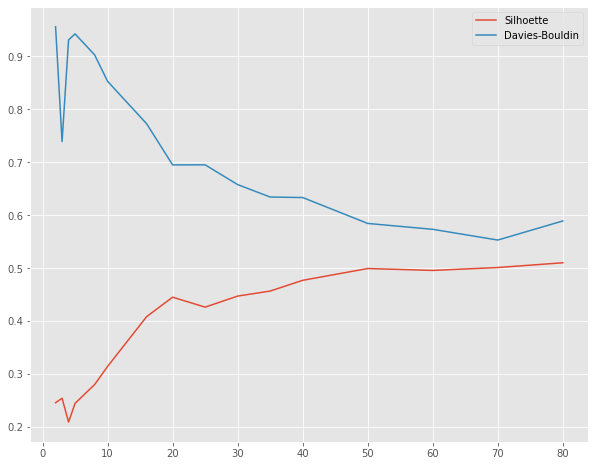

In [49]:
plt.figure(figsize=(10, 8))
plt.plot(results['n_clusters'], results['ss'], label='Silhoette')
plt.plot(results['n_clusters'], results['dbs'], label='Davies-Bouldin')
plt.legend()

In [50]:
## how to define number of clusters?

N_CLUSTERS = 70
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demandPivot)

## add labels to dataset
demandPivot['label'] = cluster_labels
dataClustered = data.merge(demandPivot.reset_index()[['product_rk', 'label']], on='product_rk', how='left')
dataClustered = dataClustered.sort_values('period_start_dt')
dataClustered.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,product_lvl_rk3,product_lvl_rk2,label
0,94839,1143,2018-07-02,1.590909,0.0,0.0,199.0,199.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,39,10,10125,9711,14.0
1235962,35690,764,2018-07-02,1.000000,0.0,0.0,399.0,399.0,0.0,1.0,...,1.0,1.200000,1.0,1.200000,1.0,219,10,7477,112093,45.0
1235961,35693,764,2018-07-02,0.278146,0.0,0.0,519.0,363.3,0.0,1.0,...,1.0,1.000000,1.0,0.839726,1.0,219,10,7477,112093,45.0
1235960,25166,764,2018-07-02,0.153005,0.0,0.0,359.0,359.0,0.0,1.0,...,1.0,1.166667,1.0,1.002049,1.0,219,10,10045,9848,27.0
1235959,52741,764,2018-07-02,1.000000,0.0,0.0,5099.0,2549.5,0.0,1.0,...,1.0,1.000000,1.0,0.751366,1.0,219,10,7728,112594,38.0


In [51]:
## now with labels

train_split_date = '2019-11-04'

dataClusteredTrain = dataClustered[dataClustered['period_start_dt'] <= train_split_date]
dataClusteredTest = dataClustered[dataClustered['period_start_dt'] > train_split_date]


print(f'Train contains {round(dataClusteredTrain.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
print(f'Test contains {round(dataClusteredTest.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
dataClusteredTrain.shape, dataClusteredTest.shape

Train contains 88.0% of data
Test contains 12.0% of data


((1515927, 145), (200274, 145))

In [84]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}


labels = dataClusteredTest['label'].unique()
labels = labels[~np.isnan(labels)]

for label in labels:
    
    X_train, y_train = dataClusteredTrain[dataClusteredTrain['label'] == label]\
            [train_cols].values, dataClusteredTrain[dataClusteredTrain['label'] == label]['demand']
    
    X_test, y_test = dataClusteredTest[dataClusteredTest['label'] == label]\
            [train_cols].values, dataClusteredTest[dataClusteredTest['label'] == label]['demand']
    
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
#     cat = CatBoostRegressor(iterations=100, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if label not in results:
        results[label] = {}
    results[label]['mse'] = err
    results[label]['mape'] = mape
    results[label]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
dataRest = dataClusteredTest[dataClusteredTest['label'].isna()]
X_test, y_test = dataRest[train_cols].values, dataRest['demand']

preds = model1forAll.predict(X_test)

err = mean_squared_error(preds, y_test)
mape = mean_absolute_percentage_error(preds, y_test)
mae = mean_absolute_error(preds, y_test)

results['noCLuster'] = {}
results['noCLuster']['mse'] = err
results['noCLuster']['mape'] = mape
results['noCLuster']['mae'] = mae

mse_sum += err * X_test.shape[0]
mape_sum += mape * X_test.shape[0]
mae_sum += mae * X_test.shape[0]


Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 0.996701759
bestIteration = 99


bestTest = 0.8859384266
bestIteration = 99


bestTest = 0.8777818106
bestIteration = 95


bestTest = 0.9814500484
bestIteration = 99


bestTest = 0.8745050753
bestIteration = 99


bestTest = 0.8648600975
bestIteration = 99


bestTest = 0.974354273
bestIteration = 99


bestTest = 0.8680005681
bestIteration = 98


bestTest = 0.8574005478
bestIteration = 98


bestTest = 0.9723752879
bestIteration = 99


bestTest = 0.8610460556
bestIteration = 99


bestTest = 0.8524856187
bestIteration = 99

Training on fold [0/3]

bestTest = 0.7643871991
bestIteration = 99

Training on fold [1/3]

bestTest = 0.7883638027
bestIteration = 94

Training on fold [2/3]

bestTest = 0.8420587926
bestIteration = 96


bestTest = 3.298894748
bestIteration = 99


bestTest = 2.94304239
bestIteration = 99


bestTest = 2.887516242
bestIteration = 98


bestTest = 3.252345533
bestIteration = 99


bestTest = 2.87757554
bestIteration = 95


bestTest = 2.848398037
bestIteration = 


bestTest = 4.228703319
bestIteration = 99


bestTest = 4.136555261
bestIteration = 99


bestTest = 4.723712591
bestIteration = 99


bestTest = 4.182926139
bestIteration = 99


bestTest = 4.066926221
bestIteration = 99


bestTest = 4.699756331
bestIteration = 99


bestTest = 4.109725652
bestIteration = 99


bestTest = 4.003807697
bestIteration = 99

Training on fold [0/3]

bestTest = 3.89447452
bestIteration = 99

Training on fold [1/3]

bestTest = 3.692013827
bestIteration = 99

Training on fold [2/3]

bestTest = 4.033355905
bestIteration = 99


bestTest = 0.4471290054
bestIteration = 99


bestTest = 0.4091442268
bestIteration = 99


bestTest = 0.4045942992
bestIteration = 99


bestTest = 0.4387840587
bestIteration = 99


bestTest = 0.4039397659
bestIteration = 99


bestTest = 0.4003020372
bestIteration = 99


bestTest = 0.4359796055
bestIteration = 99


bestTest = 0.4005841491
bestIteration = 99


bestTest = 0.3973517412
bestIteration = 99


bestTest = 0.4347006848
bestIteration = 99


bestTest = 0.8374724213
bestIteration = 95


bestTest = 0.8261164718
bestIteration = 99


bestTest = 0.9184820401
bestIteration = 99


bestTest = 0.8332559577
bestIteration = 97


bestTest = 0.8286094816
bestIteration = 99

Training on fold [0/3]

bestTest = 0.8190388887
bestIteration = 96

Training on fold [1/3]

bestTest = 0.8017882278
bestIteration = 92

Training on fold [2/3]

bestTest = 0.8099330402
bestIteration = 99


bestTest = 0.999301871
bestIteration = 99


bestTest = 0.908827662
bestIteration = 99


bestTest = 0.9006799321
bestIteration = 99


bestTest = 0.9914534425
bestIteration = 99


bestTest = 0.8996672655
bestIteration = 99


bestTest = 0.8869975339
bestIteration = 99


bestTest = 0.9876507886
bestIteration = 99


bestTest = 0.8885716983
bestIteration = 99


bestTest = 0.8774310612
bestIteration = 99


bestTest = 0.9861164109
bestIteration = 99


bestTest = 0.882593685
bestIteration = 99


bestTest = 0.876390557
bestIteration = 99

Training on fold [0/3]

bestTest = 


bestTest = 3.536395265
bestIteration = 99


bestTest = 3.468478738
bestIteration = 99

Training on fold [0/3]

bestTest = 3.243911546
bestIteration = 37

Training on fold [1/3]

bestTest = 2.853878623
bestIteration = 98

Training on fold [2/3]

bestTest = 3.421831996
bestIteration = 99


bestTest = 1.486946411
bestIteration = 99


bestTest = 1.327234628
bestIteration = 99


bestTest = 1.318118616
bestIteration = 97


bestTest = 1.473502312
bestIteration = 99


bestTest = 1.302854137
bestIteration = 99


bestTest = 1.297702518
bestIteration = 99


bestTest = 1.464981806
bestIteration = 99


bestTest = 1.295826096
bestIteration = 99


bestTest = 1.277885867
bestIteration = 98


bestTest = 1.462915999
bestIteration = 99


bestTest = 1.28509418
bestIteration = 98


bestTest = 1.275374219
bestIteration = 96

Training on fold [0/3]

bestTest = 1.343501496
bestIteration = 95

Training on fold [1/3]

bestTest = 1.26931224
bestIteration = 99

Training on fold [2/3]

bestTest = 1.300789677
best


bestTest = 20.56536954
bestIteration = 17

Training on fold [2/3]

bestTest = 25.69443566
bestIteration = 32


bestTest = 21.94304081
bestIteration = 99


bestTest = 20.16080548
bestIteration = 99


bestTest = 19.53504598
bestIteration = 98


bestTest = 21.70076091
bestIteration = 99


bestTest = 19.05518434
bestIteration = 98


bestTest = 18.95860759
bestIteration = 98


bestTest = 21.83005715
bestIteration = 99


bestTest = 19.34022858
bestIteration = 96


bestTest = 18.77180531
bestIteration = 88


bestTest = 22.11126685
bestIteration = 99


bestTest = 18.82615211
bestIteration = 99


bestTest = 18.53000182
bestIteration = 94

Training on fold [0/3]

bestTest = 9.843853075
bestIteration = 97

Training on fold [1/3]

bestTest = 12.63550666
bestIteration = 50

Training on fold [2/3]

bestTest = 15.48099746
bestIteration = 99


bestTest = 23.04585862
bestIteration = 99


bestTest = 22.45899595
bestIteration = 38


bestTest = 22.71067041
bestIteration = 28


bestTest = 23.06131587
best


bestTest = 7.930343152
bestIteration = 40


bestTest = 7.90928401
bestIteration = 15


bestTest = 8.35342817
bestIteration = 99


bestTest = 7.930343152
bestIteration = 40


bestTest = 7.90928401
bestIteration = 15

Training on fold [0/3]

bestTest = 5.758787177
bestIteration = 65

Training on fold [1/3]

bestTest = 5.725127031
bestIteration = 72

Training on fold [2/3]

bestTest = 7.006560012
bestIteration = 16


bestTest = 0.5842253548
bestIteration = 99


bestTest = 0.5073193984
bestIteration = 99


bestTest = 0.499636123
bestIteration = 99


bestTest = 0.579996397
bestIteration = 99


bestTest = 0.4966564091
bestIteration = 99


bestTest = 0.488896478
bestIteration = 99


bestTest = 0.577501868
bestIteration = 99


bestTest = 0.4886437823
bestIteration = 99


bestTest = 0.4780733686
bestIteration = 99


bestTest = 0.5755496491
bestIteration = 99


bestTest = 0.4825371828
bestIteration = 99


bestTest = 0.4760493918
bestIteration = 99

Training on fold [0/3]

bestTest = 0.460883134


bestTest = 0.4437527823
bestIteration = 99


bestTest = 0.4250353179
bestIteration = 99

Training on fold [0/3]

bestTest = 0.4479585223
bestIteration = 99

Training on fold [1/3]

bestTest = 0.4346323643
bestIteration = 99

Training on fold [2/3]

bestTest = 0.4494209942
bestIteration = 99


bestTest = 1.865034593
bestIteration = 99


bestTest = 1.61849499
bestIteration = 57


bestTest = 1.602843156
bestIteration = 25


bestTest = 1.915738839
bestIteration = 99


bestTest = 1.600038909
bestIteration = 74


bestTest = 1.62259817
bestIteration = 40


bestTest = 1.949565637
bestIteration = 99


bestTest = 1.616511721
bestIteration = 74


bestTest = 1.624807786
bestIteration = 31


bestTest = 1.948658261
bestIteration = 99


bestTest = 1.650322058
bestIteration = 69


bestTest = 1.632487334
bestIteration = 37

Training on fold [0/3]

bestTest = 1.789321499
bestIteration = 63

Training on fold [1/3]

bestTest = 1.592305418
bestIteration = 92

Training on fold [2/3]

bestTest = 1.478398206

In [85]:
mse = mse_sum / dataClusteredTest.shape[0]
mae = mae_sum / dataClusteredTest.shape[0]
mape = mape_sum / dataClusteredTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 6.225589060615557
	MAPE: 0.679983388237477
	MAE: 0.8253877531966444


{15.0: {'mse': 0.9328551264731249,
  'mape': 0.7002097159981582,
  'mae': 0.4996904377133729},
 6.0: {'mse': 10.128305353513632,
  'mape': 0.7543924331830574,
  'mae': 1.7829612256201346},
 14.0: {'mse': 4.638105143194019,
  'mape': 0.5864986576825956,
  'mae': 1.2482024523862443},
 1.0: {'mse': 8.987782073532104,
  'mape': 0.7456423765869843,
  'mae': 1.7087763173567156},
 12.0: {'mse': 1.5300160958221187,
  'mape': 0.8466580575538607,
  'mae': 0.6941786782775387},
 28.0: {'mse': 1.2833366173680332,
  'mape': 0.6311379708920191,
  'mae': 0.6606581329014979},
 56.0: {'mse': 0.4206468693237321,
  'mape': 0.744868859029114,
  'mae': 0.441579177067884},
 46.0: {'mse': 4.146505734047358,
  'mape': 0.7394492801269894,
  'mae': 1.1387263816090192},
 10.0: {'mse': 0.15963272377829926,
  'mape': 0.7507734387700807,
  'mae': 0.20787622895604368},
 0.0: {'mse': 2.5087090391669125,
  'mape': 0.5837413083967924,
  'mae': 1.0539895822158136},
 66.0: {'mse': 4.716967832086949,
  'mape': 0.6517349099

## product_rk - city

In [86]:
## calculate mean demand for every pair product-city

demandByCity = pd.pivot_table(dataTrain.groupby(['product_rk', 'city'])['demand'].mean().reset_index(), 
                                      index='product_rk', values='demand', columns='city', fill_value=0).rename_axis(None, axis=1)
demandByCity.columns = demandByCity.columns.astype(str)
demandByCity.head()



,32,39,54,189,203,219
product_rk,,,,,,
11478,0.000000,0.000000,0.000000,0.364772,0.606614,0.557924
11506,0.000000,0.000000,0.000000,0.634120,0.232596,0.181542
11530,0.000000,0.000000,0.000000,0.184109,0.343941,0.435320
11549,0.226528,0.669399,0.477866,0.370414,0.559248,0.642139
11559,1.000000,1.000000,1.000000,0.255738,0.664884,1.000000


**Silhouette score** aka Silhouette Coefficient is an evaluation metric that results in the range of -1 to 1. A score near 1 signifies the best importance that the data point is very compact within the cluster to which it belongs and far away from the other clusters. The score near -1 signifies the least or worst importance of the data point. A score near 0 signifies overlapping clusters. 

**Davies-Bouldin Index** score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters that are farther apart and less dispersed will result in a better score. The minimum score is 0, with lower values indicating better clustering.

In [94]:
results = pd.DataFrame({'n_clusters': [], 'ss': [], 'dbs': []})
n_clusters = [2, 3, 4, 5, 8, 10, 16, 20]


for i, n_cluster in tqdm(enumerate(n_clusters), total=len(n_clusters)):
    df_cluster = demandByCity.copy()
    agcl = AgglomerativeClustering(n_clusters=n_cluster)
    cluster_labels = agcl.fit_predict(df_cluster)

    df_cluster['label'] = cluster_labels
    ss = silhouette_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    dbs = davies_bouldin_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    
    results.loc[i] = [n_cluster, ss, dbs]

  0%|          | 0/8 [00:00<?, ?it/s]

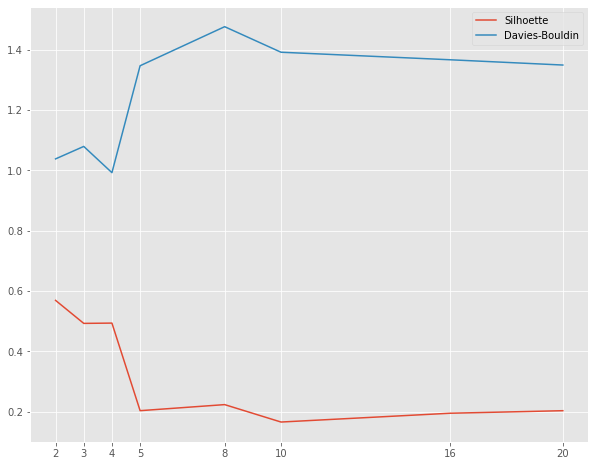

In [97]:
plt.figure(figsize=(10, 8))
plt.plot(results['n_clusters'], results['ss'], label='Silhoette')
plt.plot(results['n_clusters'], results['dbs'], label='Davies-Bouldin')
plt.xticks([2, 3, 4, 5, 8, 10, 16, 20])
plt.legend()

In [98]:
## how to define number of clusters?

N_CLUSTERS = 2
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demandByCity)

## add labels to dataset
demandByCity['label'] = cluster_labels
dataClustered = data.merge(demandByCity.reset_index()[['product_rk', 'label']], on='product_rk', how='left')
dataClustered = dataClustered.sort_values('period_start_dt')
dataClustered.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,product_lvl_rk3,product_lvl_rk2,label
0,94839,1143,2018-07-02,1.590909,0.0,0.0,199.0,199.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,39,10,10125,9711,0.0
1235962,35690,764,2018-07-02,1.000000,0.0,0.0,399.0,399.0,0.0,1.0,...,1.0,1.200000,1.0,1.200000,1.0,219,10,7477,112093,1.0
1235961,35693,764,2018-07-02,0.278146,0.0,0.0,519.0,363.3,0.0,1.0,...,1.0,1.000000,1.0,0.839726,1.0,219,10,7477,112093,1.0
1235960,25166,764,2018-07-02,0.153005,0.0,0.0,359.0,359.0,0.0,1.0,...,1.0,1.166667,1.0,1.002049,1.0,219,10,10045,9848,1.0
1235959,52741,764,2018-07-02,1.000000,0.0,0.0,5099.0,2549.5,0.0,1.0,...,1.0,1.000000,1.0,0.751366,1.0,219,10,7728,112594,1.0


In [99]:
dataClustered['label'].value_counts(normalize=True)

1.0    0.701986
0.0    0.298014
Name: label, dtype: float64

<AxesSubplot:xlabel='city'>

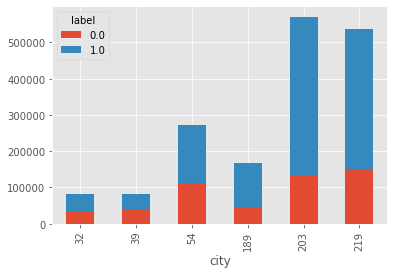

In [100]:
dataClustered.groupby(['city', 'label'])['demand'].count().unstack().plot.bar(stacked=True)

In [101]:
## now with labels

train_split_date = '2019-11-04'

dataClusteredTrain = dataClustered[dataClustered['period_start_dt'] <= train_split_date]
dataClusteredTest = dataClustered[dataClustered['period_start_dt'] > train_split_date]


print(f'Train contains {round(dataClusteredTrain.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
print(f'Test contains {round(dataClusteredTest.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
dataClusteredTrain.shape, dataClusteredTest.shape

Train contains 88.0% of data
Test contains 12.0% of data


((1515927, 145), (200274, 145))

In [102]:
# main_cols = ['product_rk', 'store_location_rk', 'PROMO1_FLAG', 'PROMO2_FLAG', 'PROMO12_FLAG', 'city']
# lag_cols = dataClusteredTrain.columns[dataClusteredTrain.columns.str.contains('demand_')]

# train_cols = main_cols + list(lag_cols)

# X_train, y_train = dataClusteredTrain[train_cols].values, dataClusteredTrain['demand']
# X_test, y_test = dataClusteredTest[train_cols].values, dataClusteredTest['demand']

In [103]:
dataClusteredTest['label'].isna().sum()

5111

5к строк оказались некластеризованными, предскажем их общей моделью

In [104]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}

for label in dataClusteredTrain['label'].unique():
    
    X_train, y_train = dataClusteredTrain[dataClusteredTrain['label'] == label]\
            [train_cols].values, dataClusteredTrain[dataClusteredTrain['label'] == label]['demand']
    
    X_test, y_test = dataClusteredTest[dataClusteredTest['label'] == label]\
            [train_cols].values, dataClusteredTest[dataClusteredTest['label'] == label]['demand']
    
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
#     cat = CatBoostRegressor(iterations=100, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if label not in results:
        results[label] = {}
    results[label]['mse'] = err
    results[label]['mape'] = mape
    results[label]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
dataRest = dataClusteredTest[dataClusteredTest['label'].isna()]
X_test, y_test = dataRest[train_cols].values, dataRest['demand']

preds = model1forAll.predict(X_test)

err = mean_squared_error(preds, y_test)
mape = mean_absolute_percentage_error(preds, y_test)
mae = mean_absolute_error(preds, y_test)

results['noCLuster'] = {}
results['noCLuster']['mse'] = err
results['noCLuster']['mape'] = mape
results['noCLuster']['mae'] = mae

mse_sum += err * X_test.shape[0]
mape_sum += mape * X_test.shape[0]
mae_sum += mae * X_test.shape[0]



bestTest = 3.880067593
bestIteration = 99


bestTest = 3.554581485
bestIteration = 99


bestTest = 3.518244912
bestIteration = 99


bestTest = 3.804315178
bestIteration = 99


bestTest = 3.505817973
bestIteration = 98


bestTest = 3.469995229
bestIteration = 99


bestTest = 3.773782146
bestIteration = 99


bestTest = 3.473808103
bestIteration = 98


bestTest = 3.425327419
bestIteration = 97


bestTest = 3.7606246
bestIteration = 99


bestTest = 3.466028637
bestIteration = 99


bestTest = 3.417410687
bestIteration = 96

Training on fold [0/3]

bestTest = 3.406395241
bestIteration = 97

Training on fold [1/3]

bestTest = 3.732701133
bestIteration = 95

Training on fold [2/3]

bestTest = 3.315693707
bestIteration = 99


bestTest = 0.7421981362
bestIteration = 99


bestTest = 0.6551812764
bestIteration = 99


bestTest = 0.6463786732
bestIteration = 99


bestTest = 0.7229757982
bestIteration = 99


bestTest = 0.6442450415
bestIteration = 99


bestTest = 0.6377933993
bestIteration = 99


be

In [105]:
mse = mse_sum / dataClusteredTest.shape[0]
mae = mae_sum / dataClusteredTest.shape[0]
mape = mape_sum / dataClusteredTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 6.222506634223407
	MAPE: 0.7298933975985175
	MAE: 0.8222867826672062


{0.0: {'mse': 11.019513855194129,
  'mape': 0.6330380411612221,
  'mae': 1.4279541048873814},
 1.0: {'mse': 0.7557123703646074,
  'mape': 0.7697197921965522,
  'mae': 0.4922049161968465},
 'noCLuster': {'mse': 91.53475141009092,
  'mape': 0.8529179606883984,
  'mae': 2.1727215165184512}}

In [107]:
dataClusteredTest['label'].value_counts()

1.0    133696
0.0     61467
Name: label, dtype: int64

## product_rk-store_location_rk

In [110]:
## calculate mean demand for every pair product-store

demandByproduct = pd.pivot_table(dataTrain.groupby(['product_rk', 'store_location_rk'])['demand'].mean().reset_index(), 
                                      index='product_rk', values='demand', columns='store_location_rk', fill_value=0).rename_axis(None, axis=1)
demandByproduct.columns = demandByproduct.columns.astype(str)
demandByproduct.head()



,453,637,764,862,1005,1034,1143,1173,1281,1380
product_rk,,,,,,,,,,
11478,0.364772,0.0,0.557924,0.000000,0.000000,0.290502,0.000000,0.000000,0.837618,0.000000
11506,0.634120,0.0,0.181542,0.000000,0.000000,0.119742,0.000000,0.000000,0.313620,0.000000
11530,0.184109,0.0,0.435320,0.000000,0.000000,0.228470,0.000000,0.000000,0.582098,0.000000
11549,0.370414,1.0,0.467757,0.448858,1.003696,0.538058,0.669399,0.226528,0.580439,0.476645
11559,0.255738,0.0,1.000000,1.000000,1.000000,0.642543,1.000000,1.000000,1.000000,0.000000


In [214]:
results = pd.DataFrame({'n_clusters': [], 'ss': [], 'dbs': []})
n_clusters = [2, 3, 4, 5, 8, 10, 16, 20]


for i, n_cluster in tqdm(enumerate(n_clusters), total=len(n_clusters)):
    df_cluster = demandByproduct.copy()
    agcl = AgglomerativeClustering(n_clusters=n_cluster)
    cluster_labels = agcl.fit_predict(df_cluster)

    df_cluster['label'] = cluster_labels
    ss = silhouette_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    dbs = davies_bouldin_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    
    results.loc[i] = [n_cluster, ss, dbs]

  0%|          | 0/8 [00:00<?, ?it/s]

In [215]:
results

,n_clusters,ss,dbs
0,2.0,0.661776,0.967286
1,3.0,0.610235,0.925854
2,4.0,0.249836,1.451627
3,5.0,0.250392,1.459298
4,8.0,0.216505,1.703008
5,10.0,0.116519,1.650303
6,16.0,0.094002,1.653022
7,20.0,0.099524,1.629859


In [111]:
## how to define number of clusters?

N_CLUSTERS = 3
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demandByproduct)

## add labels to dataset
demandByproduct['label'] = cluster_labels
dataClustered = data.merge(demandByproduct.reset_index()[['product_rk', 'label']], on='product_rk', how='left')
dataClustered = dataClustered.sort_values('period_start_dt')
dataClustered.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,product_lvl_rk3,product_lvl_rk2,label
0,94839,1143,2018-07-02,1.590909,0.0,0.0,199.0,199.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,39,10,10125,9711,2.0
1235962,35690,764,2018-07-02,1.000000,0.0,0.0,399.0,399.0,0.0,1.0,...,1.0,1.200000,1.0,1.200000,1.0,219,10,7477,112093,1.0
1235961,35693,764,2018-07-02,0.278146,0.0,0.0,519.0,363.3,0.0,1.0,...,1.0,1.000000,1.0,0.839726,1.0,219,10,7477,112093,1.0
1235960,25166,764,2018-07-02,0.153005,0.0,0.0,359.0,359.0,0.0,1.0,...,1.0,1.166667,1.0,1.002049,1.0,219,10,10045,9848,1.0
1235959,52741,764,2018-07-02,1.000000,0.0,0.0,5099.0,2549.5,0.0,1.0,...,1.0,1.000000,1.0,0.751366,1.0,219,10,7728,112594,1.0


In [112]:
## now with labels

train_split_date = '2019-11-04'

dataClusteredTrain = dataClustered[dataClustered['period_start_dt'] <= train_split_date]
dataClusteredTest = dataClustered[dataClustered['period_start_dt'] > train_split_date]


print(f'Train contains {round(dataClusteredTrain.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
print(f'Test contains {round(dataClusteredTest.shape[0] / dataClustered.shape[0], 2) * 100}% of data')
dataClusteredTrain.shape, dataClusteredTest.shape

Train contains 88.0% of data
Test contains 12.0% of data


((1515927, 145), (200274, 145))

In [113]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}

for label in dataClusteredTrain['label'].unique():
    
    X_train, y_train = dataClusteredTrain[dataClusteredTrain['label'] == label]\
            [train_cols].values, dataClusteredTrain[dataClusteredTrain['label'] == label]['demand']
    
    X_test, y_test = dataClusteredTest[dataClusteredTest['label'] == label]\
            [train_cols].values, dataClusteredTest[dataClusteredTest['label'] == label]['demand']
    
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params, verbose=0)
#     cat = CatBoostRegressor(iterations=100, verbose=0)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    err = mean_squared_error(preds, y_test)
    mape = mean_absolute_percentage_error(preds, y_test)
    mae = mean_absolute_error(preds, y_test)
    
    if label not in results:
        results[label] = {}
    results[label]['mse'] = err
    results[label]['mape'] = mape
    results[label]['mae'] = mae
    
    mse_sum += err * X_test.shape[0]
    mape_sum += mape * X_test.shape[0]
    mae_sum += mae * X_test.shape[0]
    
dataRest = dataClusteredTest[dataClusteredTest['label'].isna()]
X_test, y_test = dataRest[train_cols].values, dataRest['demand']

preds = model1forAll.predict(X_test)

err = mean_squared_error(preds, y_test)
mape = mean_absolute_percentage_error(preds, y_test)
mae = mean_absolute_error(preds, y_test)

results['noCLuster'] = {}
results['noCLuster']['mse'] = err
results['noCLuster']['mape'] = mape
results['noCLuster']['mae'] = mae

mse_sum += err * X_test.shape[0]
mape_sum += mape * X_test.shape[0]
mae_sum += mae * X_test.shape[0]



bestTest = 1.941269289
bestIteration = 99


bestTest = 1.770907211
bestIteration = 99


bestTest = 1.753215824
bestIteration = 99


bestTest = 1.920721384
bestIteration = 99


bestTest = 1.749358372
bestIteration = 99


bestTest = 1.731949975
bestIteration = 99


bestTest = 1.907099546
bestIteration = 99


bestTest = 1.733260558
bestIteration = 99


bestTest = 1.720148656
bestIteration = 99


bestTest = 1.899087344
bestIteration = 99


bestTest = 1.722631339
bestIteration = 99


bestTest = 1.706542568
bestIteration = 99

Training on fold [0/3]

bestTest = 1.676704254
bestIteration = 99

Training on fold [1/3]

bestTest = 1.677090459
bestIteration = 99

Training on fold [2/3]

bestTest = 1.675554115
bestIteration = 99


bestTest = 0.6870270711
bestIteration = 99


bestTest = 0.6124739601
bestIteration = 99


bestTest = 0.6046996356
bestIteration = 99


bestTest = 0.6704168388
bestIteration = 99


bestTest = 0.6031354263
bestIteration = 99


bestTest = 0.5972342788
bestIteration = 99




In [55]:
mse = mse_sum / dataClusteredTest.shape[0]
mae = mae_sum / dataClusteredTest.shape[0]
mape = mape_sum / dataClusteredTest.shape[0]
print(f'Error with clustering:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')
results

Error with clustering:
	MSE: 6.5556676349903436
	MAPE: 0.7359448744065958
	MAE: 0.8308575838391371


{2.0: {'mse': 3.4377401770710994,
  'mape': 0.6266567703180357,
  'mae': 1.0643035925933706},
 1.0: {'mse': 0.7478715757527609,
  'mape': 0.7816033275143867,
  'mae': 0.4822282591699449},
 0.0: {'mse': 80.94452748877244,
  'mape': 0.7059303035487906,
  'mae': 4.141944511914414},
 'noCLuster': {'mse': 99.39654977365082,
  'mape': 1.0965212560271078,
  'mae': 2.2851791636819336}}

## product_rk-store_rk-city

In [106]:
## calculate mean demand for every pair product-store

demandByproduct = pd.pivot_table(dataTrain.groupby(['product_rk', 'store_location_rk', 'city'])['demand'].mean().reset_index(), 
                                      index=['product_rk', 'store_location_rk'], values='demand', columns='city', fill_value=0).rename_axis(None, axis=1)
demandByproduct.columns = demandByproduct.columns.astype(str)
demandByproduct.head()



32   39   54       189       203       219
product_rk store_location_rk                                             
11478      453                0.0  0.0  0.0  0.364772  0.000000  0.000000
           764                0.0  0.0  0.0  0.000000  0.000000  0.557924
           1034               0.0  0.0  0.0  0.000000  0.290502  0.000000
           1281               0.0  0.0  0.0  0.000000  0.837618  0.000000
11506      453                0.0  0.0  0.0  0.634120  0.000000  0.000000

In [ ]:
results = pd.DataFrame({'n_clusters': [], 'ss': [], 'dbs': []})
n_clusters = [2, 3, 4, 5, 8, 10]


for i, n_cluster in tqdm(enumerate(n_clusters), total=len(n_clusters)):
    df_cluster = demandByproduct.copy()
    agcl = AgglomerativeClustering(n_clusters=n_cluster)
    cluster_labels = agcl.fit_predict(df_cluster)

    df_cluster['label'] = cluster_labels
    ss = silhouette_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    dbs = davies_bouldin_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    
    results.loc[i] = [n_cluster, ss, dbs]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(results['n_clusters'], results['ss'], label='Silhoette')
plt.plot(results['n_clusters'], results['dbs'], label='Davies-Bouldin')
plt.legend()

# Horyzon Segmentation

In [117]:
dataTest['period_start_dt'].unique()

array(['2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02',
       '2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30'],
      dtype=object)

In [118]:
hor1 = ['2019-11-11', '2019-11-18', '2019-11-25', '2019-12-02']
hor2 = ['2019-12-09', '2019-12-16', '2019-12-23', '2019-12-30']

In [124]:
mse_sum = 0
mape_sum = 0
mae_sum = 0
results = {}


In [125]:
## December

main_cols = ['product_rk', 'store_location_rk',
             'PROMO1_FLAG', 'PROMO2_FLAG', 'PROMO12_FLAG',
             'city', 'product_lvl_rk3', 'product_lvl_rk2',
            'PRICE_REGULAR', 'PRICE_AFTER_DISC']
lag_cols = dataTrain.columns[(dataTrain.columns.str.contains('demand_'))]

train_cols_all = main_cols + list(lag_cols)

dataTestDecember = dataTest[dataTest['period_start_dt'].isin(hor2)]
# print(dataTrainHorizon.shape, dataTestHorizon.shape)

X_train, y_train = dataTrain[train_cols].values, dataTrain['demand']
X_test, y_test_december = dataTestDecember[train_cols].values, dataTestDecember['demand']

best_params = get_best_params(X_train, y_train)

modelHorizon = CatBoostRegressor(iterations=100, **best_params, verbose=0)

# modelHorizon = CatBoostRegressor(iterations=100, verbose=0)
modelHorizon.fit(X_train, y_train)
predsDecember = modelHorizon.predict(X_test)

err = mean_squared_error(predsDecember, y_test_december)
mape = mean_absolute_percentage_error(predsDecember, y_test_december)
mae = mean_absolute_error(predsDecember, y_test_december)

mse_sum += err * X_test.shape[0]
mape_sum += mape * X_test.shape[0]
mae_sum += mae * X_test.shape[0]

print(f'Error with horizons:\n\tMSE: {err}\n\tMAPE: {mape}\n\tMAE: {mae}')


bestTest = 1.978143045
bestIteration = 99


bestTest = 1.770515377
bestIteration = 99


bestTest = 1.762804983
bestIteration = 99


bestTest = 1.919571305
bestIteration = 99


bestTest = 1.756942831
bestIteration = 99


bestTest = 1.744955278
bestIteration = 98


bestTest = 1.899895144
bestIteration = 99


bestTest = 1.755172111
bestIteration = 94


bestTest = 1.746685206
bestIteration = 99


bestTest = 1.89084935
bestIteration = 99


bestTest = 1.752991296
bestIteration = 91


bestTest = 1.752411529
bestIteration = 39

Training on fold [0/3]

bestTest = 1.860383563
bestIteration = 94

Training on fold [1/3]

bestTest = 2.208781067
bestIteration = 98

Training on fold [2/3]

bestTest = 1.784525522
bestIteration = 95

Error with horizons:
	MSE: 10.771778267872094
	MAPE: 0.7925752707562693
	MAE: 0.9484141223319565


In [ ]:
pd.DataFrame({'feature': train_cols, 'importance': modelHorizon.feature_importances_}).\
    sort_values('importance', ascending=False).head(30)


In [126]:
## November

dataTestHorizon = dataTest[dataTest['period_start_dt'].isin(hor1)]
# print(dataTrainHorizon.shape, dataTestHorizon.shape)

X_train, y_train = dataTrain[train_cols_all].values, dataTrain['demand']
X_test, y_test_november = dataTestHorizon[train_cols_all].values, dataTestHorizon['demand']

best_params = get_best_params(X_train, y_train)

modelHorizon = CatBoostRegressor(iterations=100, **best_params, verbose=0)

modelHorizon.fit(X_train, y_train)
predsNovember = modelHorizon.predict(X_test)

err = mean_squared_error(predsNovember, y_test_november)
mape = mean_absolute_percentage_error(predsNovember, y_test_november)
mae = mean_absolute_error(predsNovember, y_test_november)

mse_sum += err * X_test.shape[0]
mape_sum += mape * X_test.shape[0]
mae_sum += mae * X_test.shape[0]

print(f'Error with horizons:\n\tMSE: {err}\n\tMAPE: {mape}\n\tMAE: {mae}')


bestTest = 1.976759824
bestIteration = 99


bestTest = 1.762117485
bestIteration = 99


bestTest = 1.751066631
bestIteration = 99


bestTest = 1.917286357
bestIteration = 99


bestTest = 1.742668662
bestIteration = 99


bestTest = 1.735780905
bestIteration = 99


bestTest = 1.897127462
bestIteration = 99


bestTest = 1.738718567
bestIteration = 99


bestTest = 1.740202984
bestIteration = 61


bestTest = 1.88728086
bestIteration = 99


bestTest = 1.738561823
bestIteration = 81


bestTest = 1.743915855
bestIteration = 57

Training on fold [0/3]

bestTest = 1.83599846
bestIteration = 99

Training on fold [1/3]

bestTest = 2.195205477
bestIteration = 99

Training on fold [2/3]

bestTest = 1.767924656
bestIteration = 98

Error with horizons:
	MSE: 2.4229972322102373
	MAPE: 0.6338808225108696
	MAE: 0.7356098647984927


In [127]:
# dataTrainHorizon = dataTrain.copy()
# mse_sum = 0

# for hor in tqdm(horizons):
    
#     dataTestHorizon = dataTest[dataTest['period_start_dt'].isin(hor)]
#     print(dataTrainHorizon.shape, dataTestHorizon.shape)
    
#     X_train, y_train = dataTrainHorizon[train_cols].values, dataTrainHorizon['demand']
#     X_test, y_test = dataTestHorizon[train_cols].values, dataTestHorizon['demand']
    
# #     best_params = get_best_params(X_train, y_train)

# #     modelHorizon = CatBoostRegressor(iterations=100, **best_params, verbose=0)
#     modelHorizon = CatBoostRegressor(iterations=100, verbose=0)
#     modelHorizon.fit(X_train, y_train)
#     preds = modelHorizon.predict(X_test)
#     mse = mean_squared_error(preds, y_test)
#     mse_sum += mse * X_test.shape[0]
#     print('Error without clustering:', mse)
    
#     dataTrainHorizon = pd.concat([dataTrainHorizon, dataTestHorizon])


In [128]:
mse = mse_sum / dataClusteredTest.shape[0]
mae = mae_sum / dataClusteredTest.shape[0]
mape = mape_sum / dataClusteredTest.shape[0]
print(f'Error with horizons:\n\tMSE: {mse}\n\tMAPE: {mape}\n\tMAE: {mae}')

Error with horizons:
	MSE: 7.0500646490208245
	MAPE: 0.7218325734992476
	MAE: 0.8535503931206132


In [146]:
pd.DataFrame({'feature': train_cols_all, 'importance': modelHorizon.feature_importances_}).\
    sort_values('importance', ascending=False).head(30)



,feature,importance
98,demand_lag52_w28D_keyproduct_rk_store_location...,14.579523
130,demand_lag52_w28D_keyproduct_rk_store_location...,4.897571
19,demand_lag8_w28D_keyproduct_rk_store_location_...,4.639464
10,demand_lag4_w28D_keyproduct_rk_store_location_...,4.428842
18,demand_lag8_w28D_keyproduct_rk_store_location_...,4.222554
83,demand_lag8_w28D_keyproduct_rk_store_location_...,4.221566
9,PRICE_AFTER_DISC,4.077430
11,demand_lag4_w28D_keyproduct_rk_store_location_...,4.020926
34,demand_lag52_w28D_keyproduct_rk_store_location...,3.919580
12,demand_lag4_w56D_keyproduct_rk_store_location_...,3.721681


In [273]:
dataNovember = dataTest[dataTest['period_start_dt'].isin(hor1)]
dataDecember = dataTest[dataTest['period_start_dt'].isin(hor2)]

In [274]:
dataNovember.groupby(['product_rk', 'store_location_rk'])['demand'].count().mean()

2.0354757073482137

In [275]:
dataDecember.groupby(['product_rk', 'store_location_rk'])['demand'].count().mean()

2.0267319139612168

In [276]:
dataNovember.groupby(['product_rk', 'store_location_rk'])['demand'].count().sort_values()

product_rk  store_location_rk
11478       453                  1
96428       453                  1
96427       764                  1
96420       862                  1
            453                  1
                                ..
109986      764                  4
30755       453                  4
109986      1143                 4
109984      1281                 4
29320       764                  4
Name: demand, Length: 43861, dtype: int64

In [277]:
dataDecember.groupby(['product_rk', 'store_location_rk'])['demand'].count().sort_values()

product_rk  store_location_rk
11478       453                  1
98898       1281                 1
98896       1380                 1
            1143                 1
98895       1281                 1
                                ..
44547       764                  4
104997      1034                 4
            1281                 4
44568       862                  4
95246       1281                 4
Name: demand, Length: 54766, dtype: int64

In [278]:
dataNovember['store_location_rk'].value_counts()

764     20792
1281    17663
1034    13656
453      9016
862      6891
1380     6464
637      6345
1143     4234
1173     4217
Name: store_location_rk, dtype: int64

In [279]:
dataDecember['store_location_rk'].value_counts()

764     24508
1281    21540
1034    14674
453     11876
1380     9185
862      9140
637      8594
1143     6199
1173     5280
Name: store_location_rk, dtype: int64

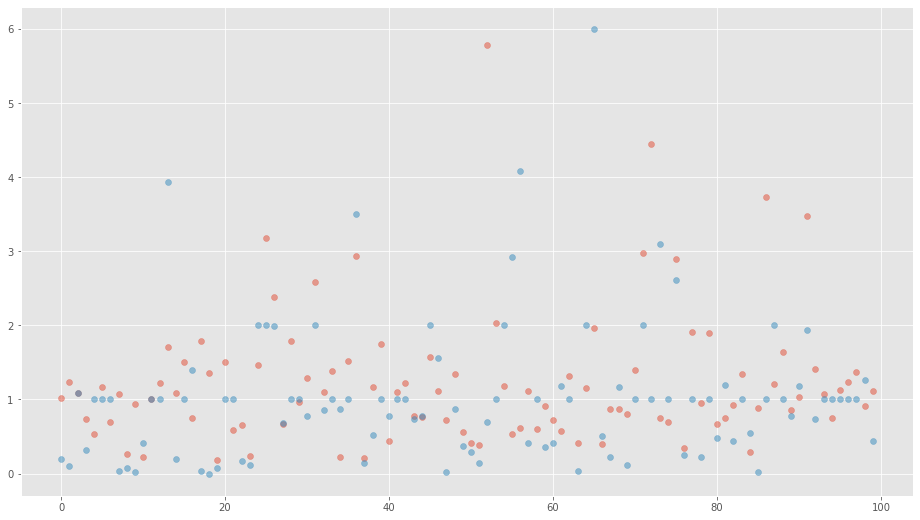

In [294]:

idxs = np.random.choice(np.arange(predsNovember.shape[0]), size=100)
plt.figure(figsize=(16, 9))

plt.scatter(np.arange(predsNovember[idxs].shape[0]), predsNovember[idxs], alpha=0.5)
plt.scatter(np.arange(predsNovember[idxs].shape[0]), y_test_november.values[idxs], alpha=0.5)

In [295]:
mean_absolute_error(predsNovember[idxs], y_test_november.values[idxs])

0.7029106728729989

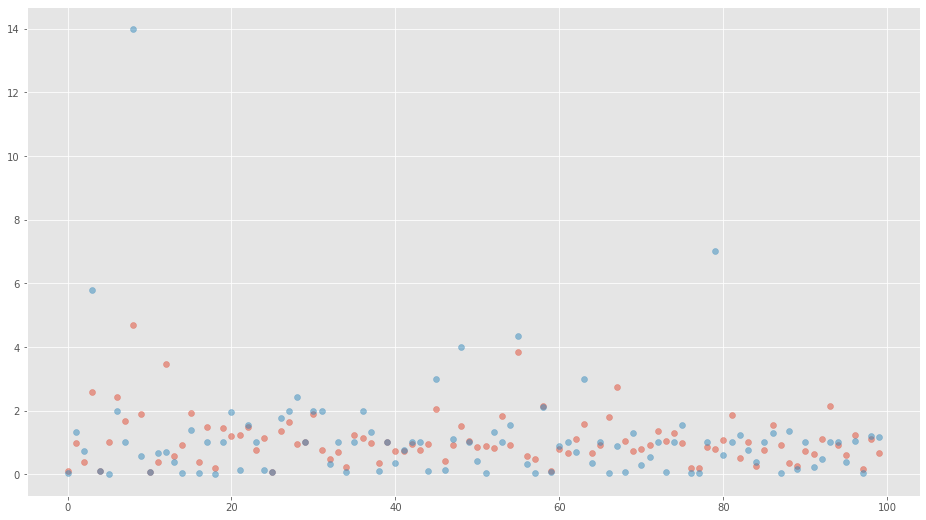

In [288]:

idxs = np.random.choice(np.arange(predsDecember.shape[0]), size=100)
plt.figure(figsize=(16, 9))

plt.scatter(np.arange(predsDecember[idxs].shape[0]), predsDecember[idxs], alpha=0.5)
plt.scatter(np.arange(predsDecember[idxs].shape[0]), y_test_december.values[idxs], alpha=0.5)

In [289]:
mean_absolute_error(predsDecember[idxs], y_test_december.values[idxs])

0.6803476280926495

In [297]:
dataTestNovember['prediction'] = predsNovember

In [299]:
dataTestNovember['error'] = abs(dataTestNovember['prediction'] - dataTestNovember['demand'])
dataTestNovember = dataTestNovember.sort_values('error', ascending=False)

<AxesSubplot:ylabel='Frequency'>

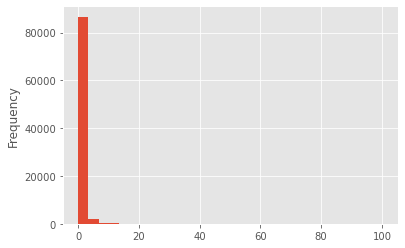

In [300]:
dataTestNovember['error'].plot.hist(bins=30)

In [350]:
dataTestNovember[dataTestNovember['error'] > 10]

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w56D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w182D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w364D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,prediction,error
1443333,40368,453,2019-11-18,104.000000,0.0,0.0,300.0,300.000000,0.0,1.0,...,2.000000,2.0000,3.750000,2.0,14.783671,4.0,189,10,3.765541,100.234459
735523,95340,1380,2019-11-18,79.000000,1.0,0.0,59.0,29.921429,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,219,10,2.498424,76.501576
526522,104624,1281,2019-11-18,67.187500,1.0,0.0,99.0,51.063158,0.0,1.0,...,2.250000,2.0000,2.250000,2.0,2.250000,2.0,203,10,3.570238,63.617262
1445876,40368,453,2019-11-25,65.000000,0.0,0.0,300.0,300.000000,0.0,1.0,...,2.000000,2.0000,3.750000,2.0,14.783671,4.0,189,10,3.765541,61.234459
521741,104285,1281,2019-11-11,64.388889,1.0,0.0,59.0,32.713393,0.0,1.0,...,3.333333,3.0000,3.000000,3.0,2.750000,3.0,203,10,4.848215,59.540674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294526,46272,764,2019-12-02,3.500000,1.0,0.0,249.0,174.300000,0.0,0.0,...,24.250000,23.4375,19.960000,18.0,18.235461,15.0,219,10,13.526792,10.026792
1286991,109714,764,2019-11-25,12.444444,1.0,0.0,1850.0,1850.000000,0.0,0.0,...,5.666667,3.0000,5.666667,3.0,5.666667,3.0,219,10,2.422105,10.022339
734661,104625,1380,2019-11-18,12.000000,1.0,0.0,99.0,63.642857,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,219,10,1.977918,10.022082
522375,110527,1281,2019-11-11,14.000000,1.0,0.0,99.0,49.500000,0.0,1.0,...,4.500000,4.5000,4.500000,4.5,4.500000,4.5,203,10,3.985299,10.014701


<AxesSubplot:ylabel='Frequency'>

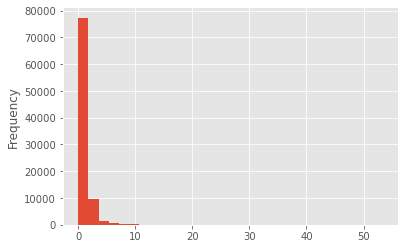

In [155]:
dataTestHorizon['prediction'].plot.hist(bins=30)

In [339]:
104624 in dataTrain['product_rk'].values

True

In [340]:
dataTestNovember

1443333    0
735523     2
526522     2
1445876    0
521741     2
          ..
523929     0
1287018    0
262207     0
674879     2
63479      0
Name: PROMO12_FLAG, Length: 89278, dtype: int64

In [147]:
## October

dataTestExp = dataTrain[dataTrain['period_start_dt'] > '2019-10-01']
dataTrainExp = dataTrain[dataTrain['period_start_dt'] <= '2019-10-01']

In [378]:
2.5e4

25000.0

In [150]:
dataTrainExp.shape

(1420815, 144)

In [152]:
trainSizes = np.arange(50000, 1400000, step=2.5e4).astype(int)

In [153]:
import numpy as np
import scipy.stats as st

In [155]:
results = {}

main_cols = ['product_rk', 'store_location_rk',
             'PROMO1_FLAG', 'PROMO2_FLAG', 'PROMO12_FLAG',
             'city', 'product_lvl_rk3', 'product_lvl_rk2',
            'PRICE_REGULAR', 'PRICE_AFTER_DISC']
lag_cols = dataTrainExp.columns[(dataTrainExp.columns.str.contains('demand_')) & (~dataTrainExp.columns.str.contains('lag4'))]

train_cols = main_cols + list(lag_cols)
n_iter = 8

for trainSize in tqdm(trainSizes):
    arr_mse, arr_mape, arr_mae = np.array([]), np.array([]), np.array([])
    
    for iter_ in tqdm(range(n_iter), leave=False):
        dataTrainExpRandom = dataTrainExp.sample(trainSize)
        
        X_train, y_train = dataTrainExpRandom[train_cols].values, dataTrainExpRandom['demand']
        X_test, y_test = dataTestExp[train_cols].values, dataTestExp['demand']


        modelExp = CatBoostRegressor(iterations=100, verbose=0)
        modelExp.fit(X_train, y_train)
        preds = modelExp.predict(X_test)

        mse = mean_squared_error(preds, y_test)
        mape = mean_absolute_percentage_error(preds, y_test)
        mae = mean_absolute_error(preds, y_test)
        
        arr_mse = np.append(arr_mse, mse)
        arr_mae = np.append(arr_mae, mae)
        arr_mape = np.append(arr_mape, mape)
#         total_mse += mse
#         total_mape += mape
#         total_mae += mae
    
    total_mse = arr_mse.mean()
    total_mape = arr_mape.mean()
    total_mae = arr_mae.mean()
    
    conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae)) 

    if trainSize not in results:
        results[trainSize] = {}
        
    results[trainSize]['mse'] = total_mse
    results[trainSize]['mae'] = total_mae
    results[trainSize]['mape'] = total_mape
    results[trainSize]['interval_mae'] = conf_interval_mae
    

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/7r/3bj773_x3qv873q1y8mhs8yh0000gn/T/ipykernel_28560/2931141881.py:41: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  conf_interval_mae = st.t.interval(alpha=0.95, df=len(arr_mae)-1, loc=np.mean(arr_mae), scale=st.sem(arr_mae))


In [156]:
dfResults = pd.DataFrame.from_dict(results, orient='index').reset_index()
dfResults

,index,mse,mae,mape,interval_mae
0,50000,1.551086,0.497348,0.724157,"(0.4915904632015567, 0.5031052078404802)"
1,75000,1.360236,0.487253,4.071465,"(0.48462172072423426, 0.48988460869829376)"
2,100000,1.356223,0.485922,0.627941,"(0.4819852564625754, 0.4898594462229394)"
3,125000,1.374561,0.485167,0.736715,"(0.4795424900051435, 0.4907914631395244)"
4,150000,1.304270,0.482250,0.681103,"(0.47973917950720707, 0.48476052461839353)"
5,175000,1.358005,0.485313,0.610310,"(0.48035337422506535, 0.4902730320151955)"
6,200000,1.219738,0.478483,0.593317,"(0.475589216232702, 0.4813771401653939)"
7,225000,1.304916,0.481339,0.647391,"(0.4788381724768147, 0.48383933469171847)"
8,250000,1.298619,0.479109,0.624477,"(0.47681381959556135, 0.48140493249429595)"
9,275000,1.248612,0.475989,0.659891,"(0.47369476086804807, 0.47828399689209866)"


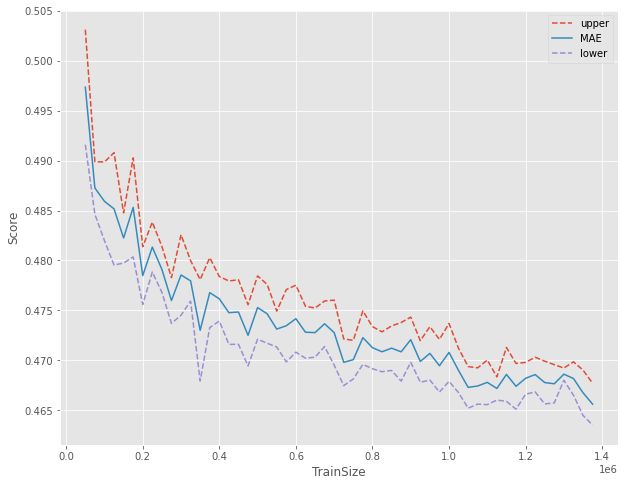

In [157]:
plt.figure(figsize=(10, 8))

# plt.plot(dfResults['index'], dfResults['mse'], label='MSE')
plt.plot(dfResults['index'], dfResults['interval_mae'].apply(lambda x: x[1]), label='upper', ls='--')
plt.plot(dfResults['index'], dfResults['mae'], label='MAE')
plt.plot(dfResults['index'], dfResults['interval_mae'].apply(lambda x: x[0]), label='lower', ls='--')

plt.xlabel('TrainSize')
plt.ylabel('Score')
plt.legend()

In [ ]:
x - n samples 
y - mean_score